# 机器学习工程师纳米学位
## 机器学习基础
## 项目 0: 预测泰坦尼克号乘客生还率

1912年，泰坦尼克号在第一次航行中就与冰山相撞沉没，导致了大部分乘客和船员身亡。在这个入门项目中，我们将探索部分泰坦尼克号旅客名单，来确定哪些特征可以最好地预测一个人是否会生还。为了完成这个项目，你将需要实现几个基于条件的预测并回答下面的问题。我们将根据代码的完成度和对问题的解答来对你提交的项目的进行评估。 

> **提示**：这样的文字将会指导你如何使用 iPython Notebook 来完成项目。

> ## 结果提交给**[kaggle](https://www.kaggle.com/c/titanic/data)**

參考閱讀
1. [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)


In [1]:
# 检查你的Python版本
from sys import version_info
if version_info.major != 3 and version_info.minor != 6:
    raise Exception('请使用Python 3.6 来完成此项目')

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [3]:
train = pd.read_csv("./data/train.csv")
test  = pd.read_csv("./data/test.csv")
submit = pd.read_csv("./data/gender_submission.csv")

# 保存测试集中的每个旅客ID
PassengerId = test['PassengerId']


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
rowNum_train=train.shape[0]
rowNum_test=test.shape[0]
print('kaggle训练数据集有多少行数据：',rowNum_train,
     ',kaggle测试数据集有多少行数据：',rowNum_test,)

kaggle训练数据集有多少行数据： 891 ,kaggle测试数据集有多少行数据： 418


从泰坦尼克号的数据样本中，我们可以看到船上每位旅客的特征

- **Survived**：是否存活（0代表否，1代表是）
- **Pclass**：社会阶级（1代表上层阶级，2代表中层阶级，3代表底层阶级）
- **Name**：船上乘客的名字
- **Sex**：船上乘客的性别
- **Age**:船上乘客的年龄（可能存在 `NaN`）
- **SibSp**：乘客在船上的兄弟姐妹和配偶的数量
- **Parch**：乘客在船上的父母以及小孩的数量
- **Ticket**：乘客船票的编号
- **Fare**：乘客为船票支付的费用
- **Cabin**：乘客所在船舱的编号（可能存在 `NaN`）
- **Embarked**：乘客上船的港口（C 代表从 Cherbourg 登船，Q 代表从 Queenstown 登船，S 代表从 Southampton 登船）



-** 使用info()函数观察发现train和test是否有空值。**

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


发现结果如下：

- **train: **   Age,Cabin,Embark
- **test: **   Age, Fare, cabin

之后我们会想办法填充这些空值 ，通常比赛能够准确预测的关键都是在如何填充空值。


** 使用describe 来观察train和test的资料分布：**

In [9]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 数据合并

In [11]:
#合并数据集，方便同时对两个数据集进行清洗
full = train.append(test,ignore_index = True)
print('合并后的数据集:',full.shape)

合并后的数据集: (1309, 12)


**查看full数据集信息**

In [12]:
#查看数据
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [13]:
#获取数据类型列的描述统计信息
full.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [14]:
#查看数据完整性
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 视图化分析数据


特征

- **Survived**：是否存活（0代表否，1代表是）
- **Pclass**：社会阶级（1代表上层阶级，2代表中层阶级，3代表底层阶级）
- **Name**：船上乘客的名字
- **Sex**：船上乘客的性别
- **Age**:船上乘客的年龄（可能存在 `NaN`）
- **SibSp**：乘客在船上的兄弟姐妹和配偶的数量
- **Parch**：乘客在船上的父母以及小孩的数量
- **Ticket**：乘客船票的编号
- **Fare**：乘客为船票支付的费用
- **Cabin**：乘客所在船舱的编号（可能存在 `NaN`）
- **Embarked**：乘客上船的港口（C 代表从 Cherbourg 登船，Q 代表从 Queenstown 登船，S 代表从 Southampton 登船）


接下来视图化做一些观察和分析。首先分析生存以及死亡的比例是否有相当大的落差，发现大概死亡的比例是6成，生存的比例大概是4成。

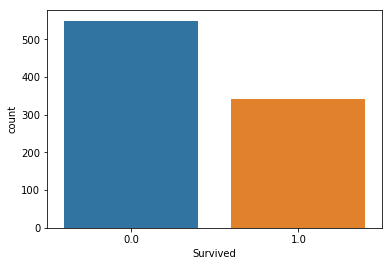

In [15]:
ax = sns.countplot(x="Survived",data=full)

#### 社会阶级生存率
**Pclass**：社会阶级（1代表上层阶级，2代表中层阶级，3代表底层阶级）

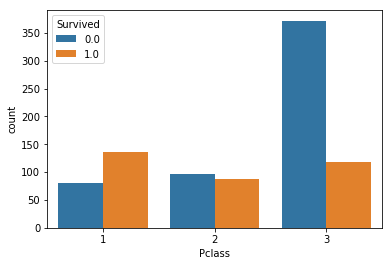

In [16]:
ax = sns.countplot(x="Pclass", hue="Survived", data=full)

结果：生存率 1 > 2 > 3 说明社会阶级越高生存率越高  

#### 不同性别的生存率
- **Sex**：船上乘客的性别 （female 女性  male 男性）

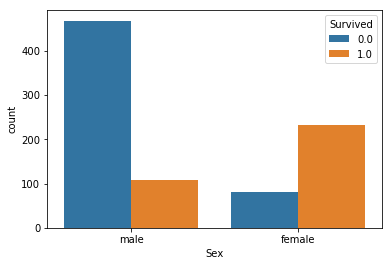

In [17]:
ax = sns.countplot(x="Sex", hue="Survived", data=full)

### 年龄生存率分布
**Age**:船上乘客的年龄（可能存在 `NaN`）

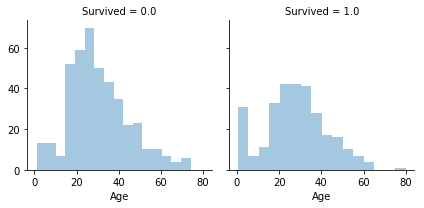

In [18]:
g = sns.FacetGrid(full, col="Survived")
g.map(sns.distplot,'Age',kde=False)

** 分析结果：** 年龄小的存活率相对比较高

### 票价存活率分析
**Fare**：乘客为船票支付的费用


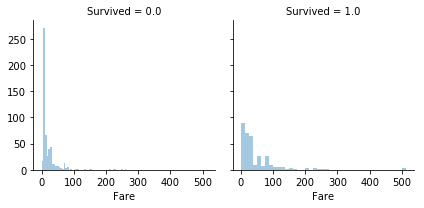

In [19]:

g = sns.FacetGrid(full, col="Survived")
g.map(sns.distplot,'Fare',kde=False)

**结果分析：** 可以发现票价比较低的，生存率比较低

- **Embarked**：乘客上船的港口（C 代表从 Cherbourg 登船，Q 代表从 Queenstown 登船，S 代表从 Southampton 登船）

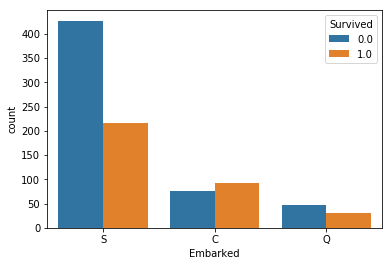

In [20]:
ax = sns.countplot(x="Embarked", hue="Survived", data=full)

**结果分析：**S港口的登船的乘客存活率比较低,C港口登船的乘客存活率比较高

### 港口跟票价是否有直接关系
前面分析了港口跟生存率的情况，我们来看看港口和票价有什么关系

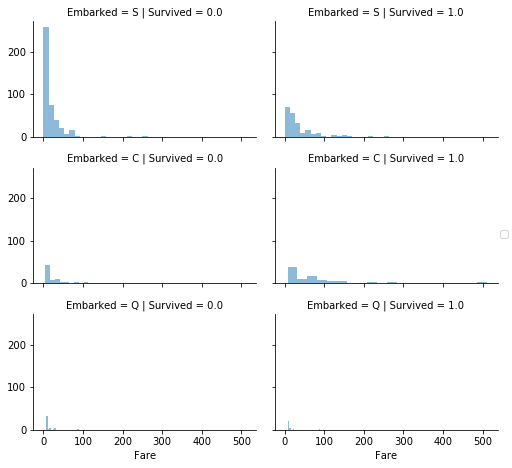

In [21]:
grid = sns.FacetGrid(full, col='Survived', row='Embarked', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Fare', alpha=.5, bins=20)
grid.add_legend();

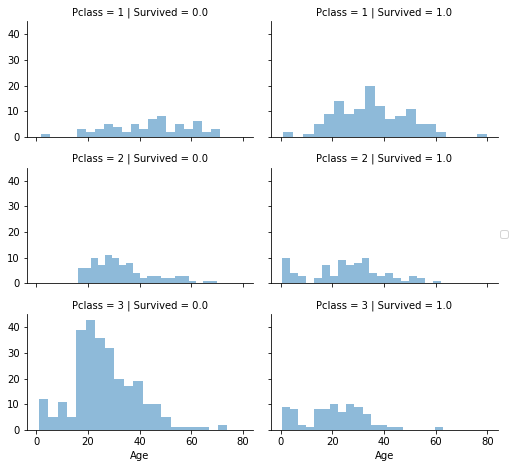

In [22]:
grid = sns.FacetGrid(full, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

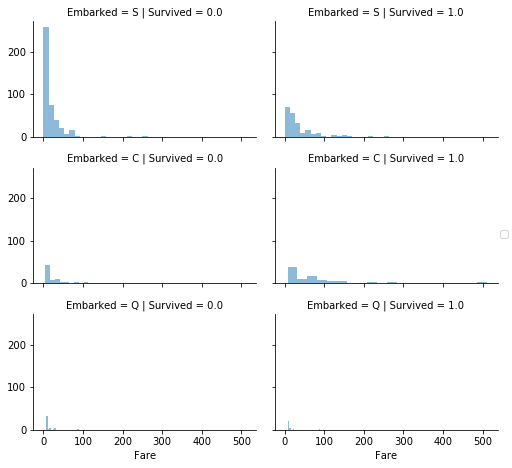

In [23]:
grid = sns.FacetGrid(full, col='Survived', row='Embarked', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Fare', alpha=.5, bins=20)
grid.add_legend();

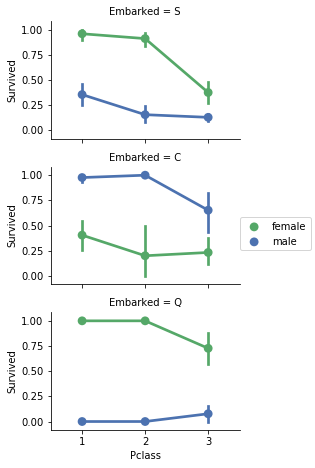

In [24]:
grid = sns.FacetGrid(full, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

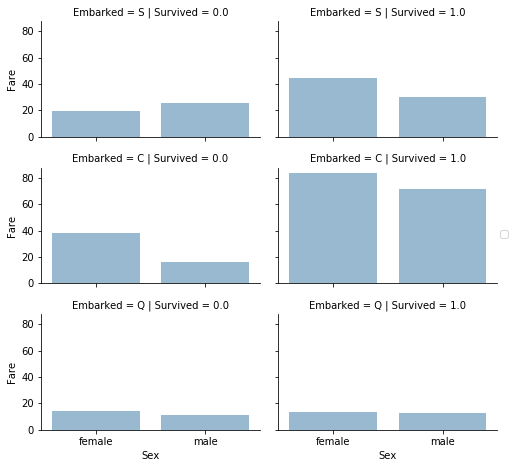

In [25]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(full, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

In [26]:
#相关性矩阵
corrDf = full.corr() 
corrDf
'''
查看各个特征与生成情况（Survived）的相关系数，
ascending=False表示按降序排列
'''
corrDf['Survived'].sort_values(ascending =False)


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

### 数据清理

3.1 数据预处理
缺失值处理
在前面，理解数据阶段，我们发现数据总共有1309行。 其中数据类型列：年龄（Age）、船舱号（Cabin）里面有缺失数据。 字符串列：登船港口（Embarked）、船舱号（Cabin）里面有缺失数据。这为我们下一步数据清洗指明了方向，只有知道哪些数据缺失数据，我们才能有针对性的处理。很多机器学习算法为了训练模型，要求所传入的特征中不能有空值。

- 如果是数值类型，用平均值取代
- 如果是分类数据，用最常见的类别取代
- 使用模型预测缺失值，例如：K-NN


In [27]:
print('处理前：')
full.info()
#年龄(Age)
full['Age']=full['Age'].fillna( full['Age'].mean() )
#船票价格(Fare)
full['Fare'] = full['Fare'].fillna( full['Fare'].mean() )
print('处理红后：')
full.info()


处理前：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
处理红后：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null in

In [28]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [29]:
#登船港口（Embarked）：查看里面数据长啥样
full['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [30]:
#分类变量Embarked，看下最常见的类别，用其填充
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [31]:
full['Embarked'] = full['Embarked'].fillna( 'S' )
#缺失数据比较多，船舱号（Cabin）缺失值填充为U，表示未知（Uknow） 
full['Cabin'] = full['Cabin'].fillna( 'U' )
#检查数据处理是否正常
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [32]:
#查看最终缺失值处理情况，记住生成情况（Survived）这里一列是我们的标签，用来做机器学习预测的，不需要处理这一列
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [33]:
sex_mapDict={'male':1,
            'female':0}
#map函数：对Series每个数据应用自定义的函数计算
full['Sex']=full['Sex'].map(sex_mapDict)
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450


In [34]:
#存放提取后的特征
embarkedDf = pd.DataFrame()
embarkedDf = pd.get_dummies( full['Embarked'] , prefix='Embarked' )
embarkedDf.head()
#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full
full = pd.concat([full,embarkedDf],axis=1)
full.drop('Embarked',axis=1,inplace=True)
full.head()


,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S
0,22.0,U,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,1,0,0
2,26.0,U,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,0,0,1
4,35.0,U,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,0,0,1


In [35]:
#存放提取后的特征
pclassDf = pd.DataFrame()

#使用get_dummies进行one-hot编码，列名前缀是Pclass
pclassDf = pd.get_dummies( full['Pclass'] , prefix='Pclass' )
pclassDf.head()

#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full
full = pd.concat([full,pclassDf],axis=1)
#删掉客舱等级（Pclass）这一列
full.drop('Pclass',axis=1,inplace=True)
full.head()



,Age,Cabin,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,U,7.2500,"Braund, Mr. Owen Harris",0,1,1,1,0.0,A/5 21171,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.0,PC 17599,1,0,0,1,0,0
2,26.0,U,7.9250,"Heikkinen, Miss. Laina",0,3,0,0,1.0,STON/O2. 3101282,0,0,1,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.0,113803,0,0,1,1,0,0
4,35.0,U,8.0500,"Allen, Mr. William Henry",0,5,1,0,0.0,373450,0,0,1,0,0,1


In [36]:
#存放客舱号信息
cabinDf = pd.DataFrame()
full[ 'Cabin' ] = full[ 'Cabin' ].map( lambda c : c[0] )
##使用get_dummies进行one-hot编码，列名前缀是Cabin
cabinDf = pd.get_dummies( full['Cabin'] , prefix = 'Cabin' )
cabinDf.head()

#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full
full = pd.concat([full,cabinDf],axis=1)
#删掉客舱号这一列
full.drop('Cabin',axis=1,inplace=True)
full.head()



,Age,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Embarked_C,...,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,1,1,0.0,A/5 21171,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.0,PC 17599,1,...,0,0,0,1,0,0,0,0,0,0
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,0,0,1.0,STON/O2. 3101282,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.0,113803,0,...,0,0,0,1,0,0,0,0,0,0
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,1,0,0.0,373450,0,...,1,0,0,0,0,0,0,0,0,1


In [37]:
full.drop('Name',axis=1,inplace=True)
full.drop('Ticket',axis=1,inplace=True)

In [38]:
#相关性矩阵
corrDf = full.corr() 
corrDf
'''
查看各个特征与生成情况（Survived）的相关系数，
ascending=False表示按降序排列
'''
corrDf['Survived'].sort_values(ascending =False)


Survived       1.000000
Pclass_1       0.285904
Fare           0.257307
Cabin_B        0.175095
Embarked_C     0.168240
Cabin_D        0.150716
Cabin_E        0.145321
Cabin_C        0.114652
Pclass_2       0.093349
Parch          0.081629
Cabin_F        0.057935
Cabin_A        0.022287
Cabin_G        0.016040
Embarked_Q     0.003650
PassengerId   -0.005007
Cabin_T       -0.026456
SibSp         -0.035322
Age           -0.070323
Embarked_S    -0.149683
Cabin_U       -0.316912
Pclass_3      -0.322308
Sex           -0.543351
Name: Survived, dtype: float64

In [52]:
full_data= pd.concat( [full['Fare'],#头衔
                     full['Age'],#船舱号
                     full['Parch'],#登船港口
                     full['Sex'],#性别
                    cabinDf,pclassDf,full['Embarked_C']] , axis=1 )
full_data.head()

,Fare,Age,Parch,Sex,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Embarked_C
0,7.2500,22.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,71.2833,38.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,7.9250,26.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,53.1000,35.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,8.0500,35.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


### 构建模型

用训练数据和机器学习算法得到机器学习模型，用测试数据评估模型。

** 建立训练数据集和测试数据集 ** 

1) test.csv的数据到最后我们需要提交给**[kaggle](https://www.kaggle.com/c/titanic/data)**，里面没有"**Survived**"字段



In [53]:
# 原始数据集：特征
sourceRow = train.shape[0]
data_X = full_data.loc[0:sourceRow-1,:]
# 原始数据集：标签
data_y = train.loc[0:sourceRow-1,'Survived']

# 预测数据集；特征
pred_X = full_data.loc[sourceRow:,:]

'''
确保这里原始数据集取得是前891行的数据，不然后面的模型会有错误
'''
#训练数据集有多少行
print('原始数据集有多少行:',data_X.shape[0])
#预测数据集有多少行
print('预测数据集有多少行:',pred_X.shape[0])

原始数据集有多少行: 891
预测数据集有多少行: 418


** 原始集数据划分用于训练部分和测试部分 我这里按照8：2的比例（没有强制要求，个人习惯） **
 使用：train_test_split 

In [54]:
from sklearn.model_selection import train_test_split

# 建立模型用的训练数据集和测试数据集

train_X,test_X,train_y,test_y = train_test_split(data_X,data_y,train_size=.8,random_state = 0)

#输出数据集大小
print ('原始数据集特征：',data_X.shape, 
       '训练数据集特征：',train_X.shape ,
      '测试数据集特征：',test_X.shape)

print ('原始数据集标签：',data_y.shape, 
       '训练数据集标签：',train_y.shape ,
       '测试数据集标签：',test_y.shape)


原始数据集特征： (891, 17) 训练数据集特征： (712, 17) 测试数据集特征： (179, 17)
原始数据集标签： (891,) 训练数据集标签： (712,) 测试数据集标签： (179,)


### 选择机器学习算法

In [73]:
# 第一步导入算法
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [74]:

model = AdaBoostClassifier()
model.fit( train_X , train_y )
print("AdaBoostClassifier score:  %0.4f " % model.score(test_X , test_y))

AdaBoostClassifier score:  0.8101 


In [75]:
model = LogisticRegression()
model.fit( train_X , train_y )
print("LogisticRegression score:  %0.4f " % model.score(test_X , test_y))

LogisticRegression score:  0.8101 


In [76]:
model = SVC()
model.fit( train_X , train_y )
print("SVC score:  %0.4f " % model.score(test_X , test_y))

SVC score:  0.6983 


In [77]:
model = GradientBoostingClassifier()
model.fit( train_X , train_y )
print("GradientBoostingClassifier score:  %0.4f " % model.score(test_X , test_y))

GradientBoostingClassifier score:  0.8212 


In [78]:

model = RandomForestClassifier()
model.fit( train_X , train_y )
print("RandomForestClassifier score:  %0.4f " % model.score(test_X , test_y))

RandomForestClassifier score:  0.8212 


In [79]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit( train_X , train_y )
print("GaussianNB score:  %0.4f " % model.score(test_X , test_y))

GaussianNB score:  0.8268 


In [80]:

model = KNeighborsClassifier()
model.fit( train_X , train_y )
print("GaussianNB score:  %0.4f " % model.score(test_X , test_y))

GaussianNB score:  0.7151 


** 结论：** 随机森林，梯度提升树都不错 ，最好是随机森林和梯度提升书，接下来我们可以分别对三种分类器进行优化调参看看结果如何。

### 参数优化

** 一.对随机森林进行调参 ** 

In [96]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Build a classification task using 3 informative features

param_test1 = {'n_estimators':range(10,200,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                                           min_samples_leaf=20,max_depth=3,max_features='sqrt' ,oob_score=True,random_state=0), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit( train_X , train_y )
gsearch1.best_params_, gsearch1.best_score_
 


({'n_estimators': 10}, 0.83127519382120296)

In [98]:
param_test2 = {'max_depth':range(2,8,1), 'min_samples_split':range(10,81,10)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 10, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=0),
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit( train_X , train_y )
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_samples_split': 60}, 0.84763940783663883)

In [99]:
param_test3 = {'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 10, max_depth=7,min_samples_split=60,
                                  max_features='sqrt' ,oob_score=True, random_state=0),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit( train_X , train_y )
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 20}, 0.84763940783663883)

In [107]:
param_test4 = {'max_features':[1,2,3,4,5,6,7]}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 10, max_depth=7, min_samples_split=60,
                                  min_samples_leaf=20 ,oob_score=True, random_state=0),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit( train_X , train_y )
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 4}, 0.84763940783663883)

In [111]:
rf2 = RandomForestClassifier(n_estimators= 10, max_depth=7, min_samples_split=60,max_features=4,
                                  min_samples_leaf=20 ,oob_score=True, random_state=0)
rf2.fit(train_X,train_y)

rf2.oob_score_


gbm1 = RandomForestClassifier(n_estimators= 10, max_depth=7, min_samples_split=60,max_features=4,
                                  min_samples_leaf=20 ,oob_score=True, random_state=0)
gbm1.fit(train_X,train_y)


y_pred = gbm1.predict(pred_X)

print('Misclassified samples: %d' % (test_y != y_pred).sum())



Misclassified samples: 31


In [113]:
from sklearn.metrics import accuracy_score


print('Accuracy: %0.4f' % accuracy_score(test_y,y_pred))

Accuracy: 0.8268


**梯度提升树(GBDT)调参： **

In [86]:
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=10,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=0), 
                       param_grid = param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(train_X,train_y)
gsearch1.best_params_, gsearch1.best_score_


({'n_estimators': 50}, 0.85547102864239744)

In [88]:
param_test2 = {'max_depth':range(2,14,2), 'min_samples_split':range(10,101,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=0), 
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(train_X,train_y)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 6, 'min_samples_split': 10}, 0.85888445144584113)

In [89]:
param_test3 = {'min_samples_split':range(10,101,10), 'min_samples_leaf':range(10,101,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=6,
                                     max_features='sqrt', subsample=0.8, random_state=0), 
                       param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(train_X,train_y)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 20, 'min_samples_split': 10}, 0.85888445144584113)

In [90]:
param_test3 = {'max_features':range(1,16,1), 'learning_rate':[0.01,0.03,0.1],'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier( n_estimators=50,max_depth=6,min_samples_leaf =20,  
                                                                min_samples_split =10,
                                     random_state=0), 
                       param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(train_X,train_y)
gsearch3.best_params_, gsearch3.best_score_

({'learning_rate': 0.1, 'max_features': 4, 'subsample': 0.8},
 0.85888445144584113)

In [93]:
gbm1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=6, min_samples_leaf =20,min_samples_split =10, 
                                  max_features=4, subsample=0.8, random_state=0)
gbm1.fit(train_X,train_y)

print("GradientBoostingClassifier score:  %0.4f " % gbm1.score(test_X , test_y))


GradientBoostingClassifier score:  0.8547 


In [94]:
from sklearn.metrics import accuracy_score

y_pred = gbm1.predict(test_X)

print('Accuracy: %0.2f' % accuracy_score(test_y,y_pred))

Accuracy: 0.85


** 结果：最后使用梯度提升树得出的准确率为：0.85  ** 

1) 提交给**[kaggle](https://www.kaggle.com/c/titanic/data)**，里面没有"**Survived**"字段

In [114]:
#使用机器学习模型，对预测数据集中的生存情况进行预测
pred_Y = gbm1.predict(pred_X)

'''
生成的预测值是浮点数（0.0,1,0）
但是Kaggle要求提交的结果是整型（0,1）
所以要对数据类型进行转换
'''
pred_Y=pred_Y.astype(int)
#乘客id
passenger_id = test['PassengerId']
#数据框：乘客id，预测生存情况的值
predDf = pd.DataFrame( 
    { 'PassengerId': passenger_id , 
     'Survived': pred_Y } )
predDf.shape
predDf.head()
#保存结果
predDf.to_csv( 'titanic_pred.csv' , index = False )

### 参考资料

* [许辙-kaggle泰坦尼克号生存率分析（入门）个人总结](https://www.jianshu.com/p/06c2ee7e5c68)
* [Yeh Jame - 泰坦尼克号生存预测](https://medium.com/@yehjames/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC4-1%E8%AC%9B-kaggle%E7%AB%B6%E8%B3%BD-%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E7%94%9F%E5%AD%98%E9%A0%90%E6%B8%AC-%E5%89%8D16-%E6%8E%92%E5%90%8D-a8842fea7077)
* [Anisotropic - Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)